# Gesture Recognition Project
This project involves building a 3D Convolutional Neural Network (CNN) to correctly recognize hand gestures by a user to control a smart TV.

The objective of this projects is to build a hand gesture recognition model that can be hosted on a camera installed in a smart TV that can understand 5 gestures. 

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
-	Thumbs up:  Increase the volume
-	Thumbs down: Decrease the volume
-	Left swipe: 'Jump' backwards 10 seconds
-	Right swipe: 'Jump' forward 10 seconds  
-	Stop: Pause the movie

## Understanding the DataSet:

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

### Let's visualise the sample data for one of the action "right-swipe" for one video (image-sequence)




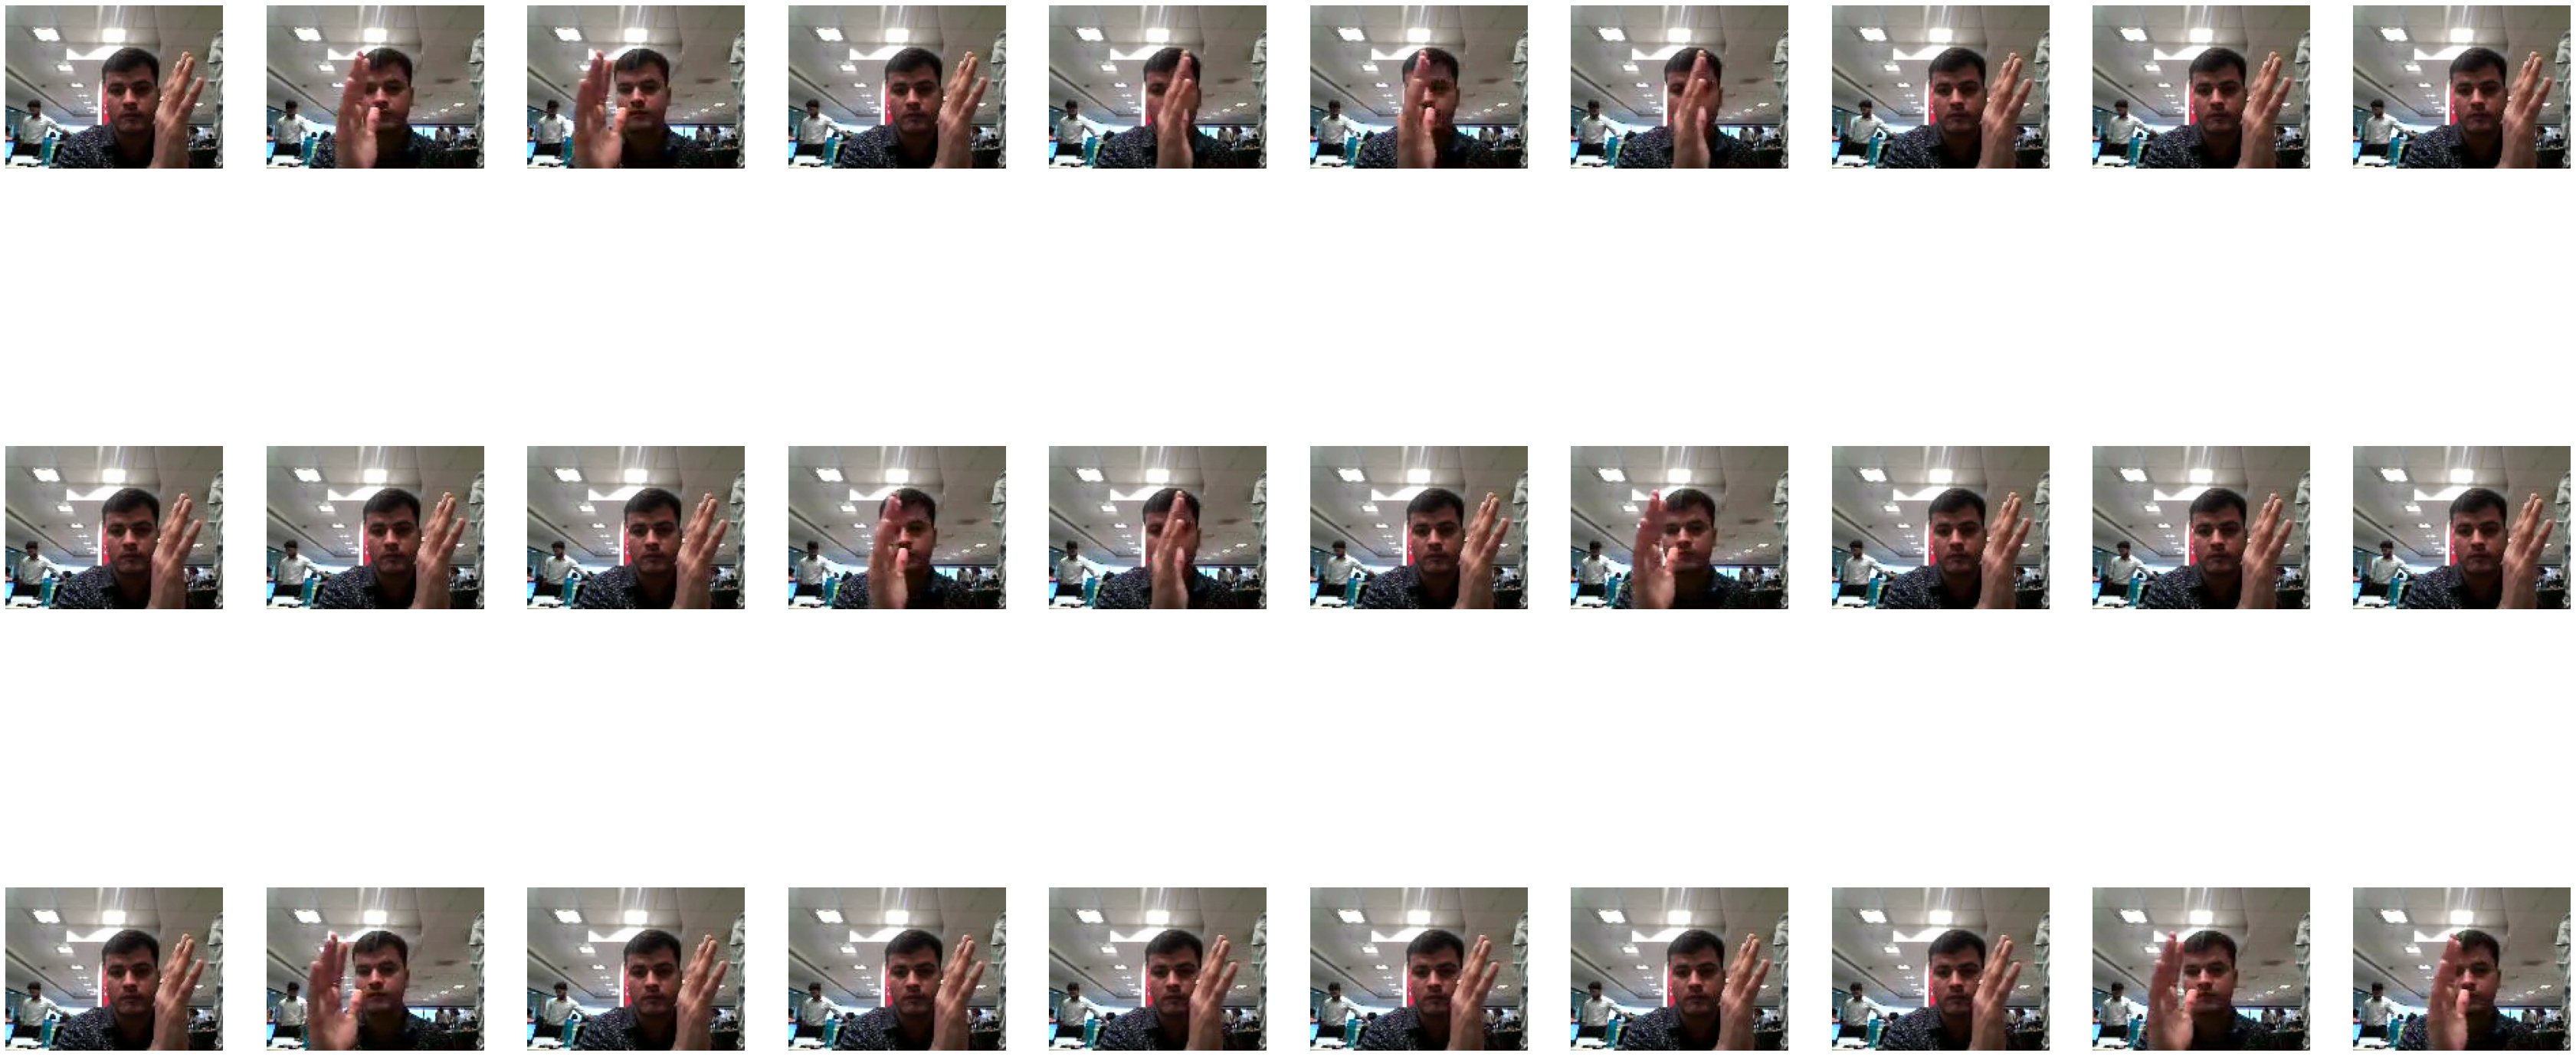

In [19]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read all images from the specified directory
images = []
for img_path in glob.glob('/home/datasets/Project_data/train/WIN_20180926_18_07_05_Pro_Right_Swipe_new/*.png'):
    images.append(mpimg.imread(img_path))

# Plot the images in a grid
plt.figure(figsize=(60, 30))
columns = 10
rows = len(images) // columns + (1 if len(images) % columns else 0)  # Ensure rows is an integer

for i, image in enumerate(images):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')  # Optional: Remove axes for better visualization

plt.show()

In [21]:
# Doing the required imports:

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout,
    Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, ZeroPadding3D, LSTM
)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy


In [4]:
pip install opencv-python

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [22]:
# Importing the python basic libraries and functions:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os

# Importing additional libraries which might be needed for image pre-processing :

#import resize as imresize
#import sckikit-image as skimage
import cv2
import imageio as imio
from PIL import Image

In [3]:
# Random seed is done to handle the reproducibility of the network and so that the results don't vary drastically:

In [23]:
import numpy as np
import random as rn
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [7]:
# Check the Tensor flow version :
import tensorflow as tf
print(tf.__version__)

2.7.0


In [24]:
# This prevents that resource exhausted error assuming you're batch size is within reason.
import tensorflow as tf

# Configure TensorFlow to allow GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth allowed")
    except RuntimeError as e:
        print(e)

GPU memory growth allowed


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [25]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

#experiment with the batch size
batch_size = 25

In [26]:
# Custom function to crop image :

def crop_img(img, scale=1.0):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. 

In [27]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,64,64,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.10)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,64,64,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.10)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [28]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 5
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# First Base Model : Conv 3D Model with 5 epochs, 25 batch size 
### Without dropouts in Conv layer and with batch normalization

### Input image size 64X64 , adam optimiser with learning rate 0.0002 with decay, 18 images as input out of 30 

In [29]:
# Building the first model which is 3D Conv model:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, BatchNormalization, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers

# Building the first model which is 3D Conv model:
modelConv3D_1 = Sequential()

modelConv3D_1.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,64,64,3)))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_1.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_1.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_1.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_1.add(Flatten())
modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(5, activation='softmax'))

# Optimizer
optimiser = optimizers.Adam(learning_rate=0.0002, decay=1e-6)

# Compile model
modelConv3D_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(modelConv3D_1.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 64, 64, 8)     656       
                                                                 
 activation_4 (Activation)   (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization_6 (Batc  (None, 18, 64, 64, 8)    32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 32, 32, 8)     0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_5 (Activation)   (None, 9, 32, 32, 16)    

In [30]:
print("Total Params in model:", modelConv3D_1.count_params())

Total Params in model: 144421


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [31]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
import datetime

# Example current date-time
curr_dt_time = datetime.datetime.now()

# Define the model name
model_name = 'model_init_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it doesn't exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the file path for saving models with .keras extension
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Create ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'  # Replacing period with save_freq
)

# Create ReduceLROnPlateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1
)

# Combine callbacks
callbacks_list = [checkpoint, LR]


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [33]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [34]:
# Modified the fit generator to use multiproessing to improve the training time :

# This is for first model 3D Conv model: (modelConv3D_1)

history = modelConv3D_1.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)


Source path =  /home/datasets/Project_data/train ; batch size = 25
Epoch 1/5


2024-12-26 14:33:31.992404: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


27/27 [==============================] - ETA: 0s - loss: 2.1667 - categorical_accuracy: 0.2383Source path =  /home/datasets/Project_data/val ; batch size = 25

Epoch 00001: saving model to model_init_2024-12-2614_33_22.276587/model-00001-2.16670-0.23831-1.60765-0.25000.keras
27/27 [==============================] - 45s 2s/step - loss: 2.1667 - categorical_accuracy: 0.2383 - val_loss: 1.6077 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 2/5
27/27 [==============================] - ETA: 0s - loss: 1.8657 - categorical_accuracy: 0.2956
Epoch 00002: saving model to model_init_2024-12-2614_33_22.276587/model-00002-1.86569-0.29563-1.65091-0.20000.keras
27/27 [==============================] - 25s 943ms/step - loss: 1.8657 - categorical_accuracy: 0.2956 - val_loss: 1.6509 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/5
27/27 [==============================] - ETA: 0s - loss: 1.6831 - categorical_accuracy: 0.3454
Epoch 00003: saving model to model_init_2024-12-2614_33

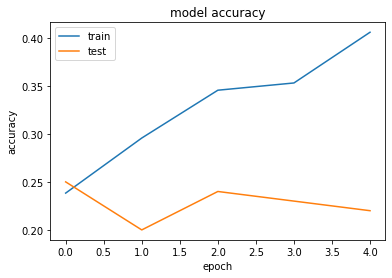

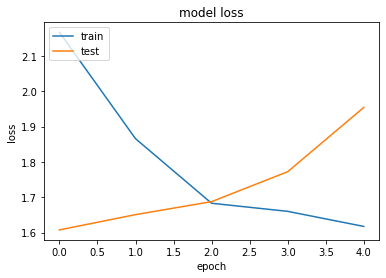

In [36]:
# Plotting the result of Model 1 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

So we have got the training accuarcy of 40% and validation accuracy of 22% in the base model

# Second Model  : Conv 3D Model with 20 epochs, 30 batch size 
Without dropouts in Conv layer and with batch normalization.
Input image size 64X64 , adam optimiser with learning rate 0.0002 without decay, 18 images as input out of 30
Changed droput to 0.50 from 0.25 in 1st dense layer 

In [37]:
batch_size = 30
num_epochs = 20

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, BatchNormalization, MaxPooling3D, Dropout, Flatten, Dense
from tensorflow.keras import optimizers

# Building the 3D Conv model
modelConv3D_2 = Sequential()

# First Conv3D layer
modelConv3D_2.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=(18, 64, 64, 3)))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Conv3D layer
modelConv3D_2.add(Conv3D(16, (3, 3, 3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Conv3D layer
modelConv3D_2.add(Conv3D(32, (3, 3, 3), padding='same'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Fourth Conv3D layer
modelConv3D_2.add(Conv3D(64, (3, 3, 3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten and Dense layers
modelConv3D_2.add(Flatten())
modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.50))

modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.25))

# Output layer
modelConv3D_2.add(Dense(5, activation='softmax'))

# Define the optimizer
optimiser = optimizers.Adam(learning_rate=0.0002)

# Compile the model
modelConv3D_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(modelConv3D_2.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 64, 64, 8)     656       
                                                                 
 activation_8 (Activation)   (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization_12 (Bat  (None, 18, 64, 64, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 32, 32, 8)     0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_9 (Activation)   (None, 9, 32, 32, 16)    

In [39]:
print("Total Params in model:", modelConv3D_2.count_params())

Total Params in model: 144421


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os

# Define the file path for saving models
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Use `.keras` as the file extension for saved models
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Update ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=False, 
    save_weights_only=False, 
    mode='auto', 
    save_freq='epoch'  # Save the model at the end of every epoch
)

# Define ReduceLROnPlateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=4, 
    verbose=1
)

# List of callbacks
callbacks_list = [checkpoint, LR]

# Calculate steps per epoch
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1


In [41]:
# Modified the fit generator to use multiple worker without the multiprocessing training time :

# This is for second model 3D Conv model: )
history = modelConv3D_2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    initial_epoch=0
)


Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.2945 - categorical_accuracy: 0.2400
Epoch 00001: saving model to model_init_2024-12-2614_33_22.276587/model-00001-2.29447-0.24000-1.61436-0.18000.keras
23/23 [==============================] - 24s 1s/step - loss: 2.2945 - categorical_accuracy: 0.2400 - val_loss: 1.6144 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 2.0428 - categorical_accuracy: 0.2806
Epoch 00002: saving model to model_init_2024-12-2614_33_22.276587/model-00002-2.04277-0.28064-1.71752-0.13000.keras
23/23 [==============================] - 20s 917ms/step - loss: 2.0428 - categorical_accuracy: 0.2806 - val_loss: 1.7175 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.9508 - categorical_accuracy: 0.2984
Epoch 00003: saving model to model_init_2024-12-2614_33_22.276587/model-00003-1.95084-0.29840-1.73744-0.130

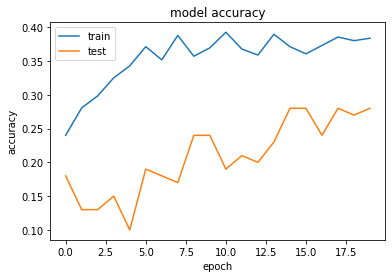

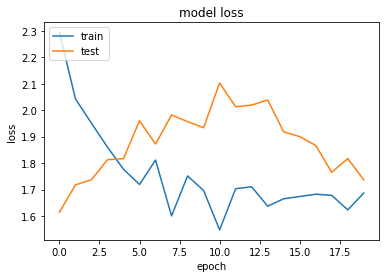

In [42]:
# Plotting the result of Model 2 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
# So we have got best validation accuracy of 40% from this model.

# Third Model  : Conv 3D Model with 20 epochs and 30 batch size , image size increaed to 84X84, reduced cropping to 3 % from 10 %
Without dropouts in Conv layer and with batch normalization.
adam optimiser with learning rate 0.0002 without decay, 18 images as input out of 30
Reverted back dropout from 0.50 to 0.25 in 1st dense layer 

In [44]:
# Modified generator function :

def generator_modified(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,84,84,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 3 % of original size :
                    image = crop_img(image, 0.03)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 3 % of original size :
                    image = crop_img(image, 0.03)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [46]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

batch_size = 30
print ('# batch_size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 30


In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, BatchNormalization, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Building the 3D Conv Model
modelConv3D_3 = Sequential()

# First Conv3D Layer
modelConv3D_3.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=(18, 84, 84, 3)))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Conv3D Layer
modelConv3D_3.add(Conv3D(16, (3, 3, 3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Conv3D Layer
modelConv3D_3.add(Conv3D(32, (3, 3, 3), padding='same'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Fourth Conv3D Layer
modelConv3D_3.add(Conv3D(64, (3, 3, 3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten Layer
modelConv3D_3.add(Flatten())

# Dense Layer 1
modelConv3D_3.add(Dense(128, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

# Dense Layer 2
modelConv3D_3.add(Dense(64, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

# Output Layer
modelConv3D_3.add(Dense(5, activation='softmax'))

# Define the optimizer with corrected learning rate
optimiser = Adam(learning_rate=0.0002)

# Compile the model
modelConv3D_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(modelConv3D_3.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 84, 84, 8)     656       
                                                                 
 activation_12 (Activation)  (None, 18, 84, 84, 8)     0         
                                                                 
 batch_normalization_18 (Bat  (None, 18, 84, 84, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 42, 42, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 42, 42, 16)     3472      
                                                                 
 activation_13 (Activation)  (None, 9, 42, 42, 16)    

In [48]:
print("Total Params in model:", modelConv3D_3.count_params())

Total Params in model: 288101


In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define the generator functions
train_generator = generator_modified(train_path, train_doc, batch_size)
val_generator = generator_modified(val_path, val_doc, batch_size)

# Define the model name and create a directory if it doesn't exist
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Filepath for saving model checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Corrected ModelCheckpoint with save_freq
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, 
                              save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnPlateau Callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)

# List of callbacks
callbacks_list = [checkpoint, LR]

# Calculate steps per epoch and validation steps
steps_per_epoch = (num_train_sequences // batch_size) + (1 if num_train_sequences % batch_size != 0 else 0)
validation_steps = (num_val_sequences // batch_size) + (1 if num_val_sequences % batch_size != 0 else 0)


In [50]:
history = modelConv3D_3.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)


Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.1423 - categorical_accuracy: 0.2383Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-12-2614_45_42.892271/model-00001-2.14227-0.23831-1.63729-0.17000.keras
23/23 [==============================] - 30s 1s/step - loss: 2.1423 - categorical_accuracy: 0.2383 - val_loss: 1.6373 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.8594 - categorical_accuracy: 0.3077
Epoch 00002: saving model to model_init_2024-12-2614_45_42.892271/model-00002-1.85940-0.30769-1.67622-0.20000.keras
23/23 [==============================] - 26s 1s/step - loss: 1.8594 - categorical_accuracy: 0.3077 - val_loss: 1.6762 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.7284 - categor

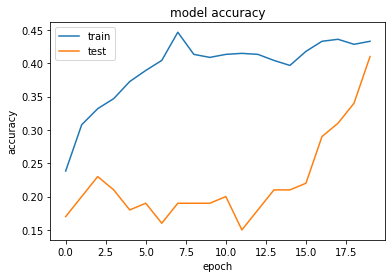

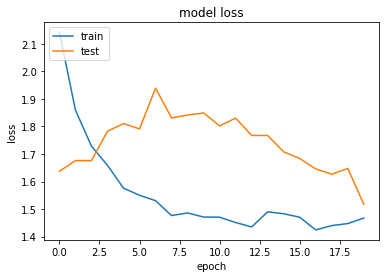

In [51]:
# Plotting the result of Model 3 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
# Best validation accuracy is 41%

# Fourth Model : Conv 3D model 
## Increase the image size to 100x100, batch size 50, epoch 30

In [53]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [54]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,100,100,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.02)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,100,100,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.02)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [55]:
modelConv3D_4 = Sequential()

modelConv3D_4.add(Conv3D(8, 
                 kernel_size=(3,3,3), 
                 input_shape=(18,100,100,3),
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(16, 
                 kernel_size=(3,3,3), 
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(32, 
                 kernel_size=(1,3,3), 
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(64, 
                 kernel_size=(1,3,3), 
                 padding='same'))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(Dropout(0.25))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
modelConv3D_4.add(Flatten())

modelConv3D_4.add(Dense(256, activation='relu'))
modelConv3D_4.add(Dropout(0.25))

modelConv3D_4.add(Dense(128, activation='relu'))
modelConv3D_4.add(Dropout(0.25))

#softmax layer
modelConv3D_4.add(Dense(5, activation='softmax'))

In [56]:
optimiser = Adam() #write your optimizer
modelConv3D_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv3D_4.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 18, 100, 100, 8)   656       
                                                                 
 batch_normalization_24 (Bat  (None, 18, 100, 100, 8)  32        
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 18, 100, 100, 8)   0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 9, 50, 50, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 9, 50, 50, 16)     3472      
                                                                 
 batch_normalization_25 (Bat  (None, 9, 50, 50, 16)   

In [57]:
print("Total Params in model:", modelConv3D_4.count_params())

Total Params in model: 651109


In [58]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

batch_size = 50
num_epochs = 30

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# training sequences = 663
# validation sequences = 100


In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
from datetime import datetime

# Generate the current date and time for model naming
curr_dt_time = datetime.now()

# Define model name and create directory if it doesn't exist
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the filepath for saving the model (change .h5 to .keras)
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Corrected ModelCheckpoint without the 'period' argument
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, 
                              save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnPlateau callback for learning rate reduction
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, cooldown=1, verbose=1)

# List of callbacks
callbacks_list = [checkpoint, LR]


In [60]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
history = modelConv3D_4.fit(train_generator, 
                            steps_per_epoch=steps_per_epoch, 
                            epochs=num_epochs, 
                            verbose=1, 
                            callbacks=callbacks_list, 
                            validation_data=val_generator, 
                            validation_steps=validation_steps, 
                            class_weight=None, 
                            initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 50
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 2.0555 - categorical_accuracy: 0.2353Source path =  /home/datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2024-12-2614_57_08.724991/model-00001-2.05552-0.23529-1.60992-0.20000.keras
14/14 [==============================] - 29s 2s/step - loss: 2.0555 - categorical_accuracy: 0.2353 - val_loss: 1.6099 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 1.5324 - categorical_accuracy: 0.2956
Epoch 00002: saving model to model_init_2024-12-2614_57_08.724991/model-00002-1.53239-0.29563-1.60753-0.19000.keras
14/14 [==============================] - 27s 2s/step - loss: 1.5324 - categorical_accuracy: 0.2956 - val_loss: 1.6075 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 1.5060 - categorical_acc

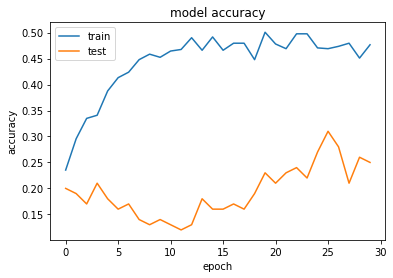

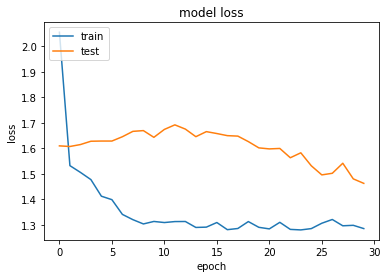

In [61]:
# Plotting the result of Model 4 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
# Best validation accuracy of 50 %.

# Model 5 : Conv 3D model

## batch size 30, increased image inputs to 30 , image size recuced to 84

In [71]:
batch_size = 30

In [81]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)] 
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,84,84,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


            yield batch_data, batch_labels

In [82]:
from datetime import datetime  

curr_dt_time = datetime.now() 
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 30
print('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 30


In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, BatchNormalization, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers

# Define the model
modelConv3D_5 = Sequential()

modelConv3D_5.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=(30, 84, 84, 3)))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_5.add(Conv3D(16, (3, 3, 3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_5.add(Conv3D(32, (3, 3, 3), padding='same'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_5.add(Conv3D(64, (3, 3, 3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_5.add(Flatten())
modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(5, activation='softmax'))

# Define the optimizer
optimiser = optimizers.Adam(learning_rate=0.0002)

# Compile the model
modelConv3D_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(modelConv3D_5.summary())


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 30, 84, 84, 8)     656       
                                                                 
 activation_28 (Activation)  (None, 30, 84, 84, 8)     0         
                                                                 
 batch_normalization_39 (Bat  (None, 30, 84, 84, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 15, 42, 42, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 15, 42, 42, 16)    3472      
                                                                 
 activation_29 (Activation)  (None, 15, 42, 42, 16)   

In [84]:
print("Total Params in model:", modelConv3D_5.count_params())

Total Params in model: 181285


In [85]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Create the model directory if it doesn't exist
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Corrected filepath with .keras extension
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Corrected ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# Define the ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)

# Combine callbacks
callbacks_list = [checkpoint, LR]

# Steps per epoch and validation steps calculation
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1


In [87]:

history = modelConv3D_5.fit(
    generator(train_path, train_doc, batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=generator(val_path, val_doc, batch_size),
    validation_steps=validation_steps,
    verbose=1
)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - 71s 3s/step - loss: 2.0136 - categorical_accuracy: 0.2609 - val_loss: 1.6292 - val_categorical_accuracy: 0.1900
Epoch 2/30
23/23 [==============================] - 62s 3s/step - loss: 1.4499 - categorical_accuracy: 0.4525 - val_loss: 1.7950 - val_categorical_accuracy: 0.2200
Epoch 3/30
23/23 [==============================] - 68s 3s/step - loss: 1.3822 - categorical_accuracy: 0.4495 - val_loss: 1.9990 - val_categorical_accuracy: 0.2400
Epoch 4/30
23/23 [==============================] - 52s 2s/step - loss: 1.2726 - categorical_accuracy: 0.4585 - val_loss: 2.1894 - val_categorical_accuracy: 0.2000
Epoch 5/30
23/23 [==============================] - 58s 3s/step - loss: 1.1877 - categorical_accuracy: 0.5128 - val_loss: 2.4958 - val_categorical_accuracy: 0.1900
Epoch 6/30
23/23 [==============================] - 54s 2s/step - loss: 1.0900 - categorical_accuracy: 0.5611 - v

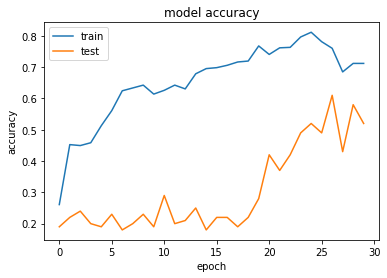

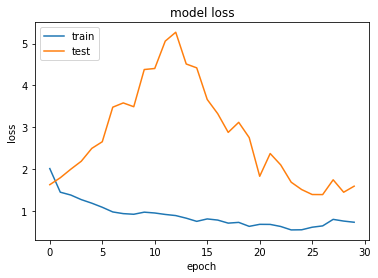

In [88]:
# Plotting the result of Model 5 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [89]:
# We have achieved the best test accuracy of 71 % and validation accuracy of 61 % by the convolutional model.

### _We have tried multiple experiments with Conv 3D model but the performance of models are not as expected, so lets try with the other models for the same problem statement._

# Model 6 : CNN - LSTM Model 

In [90]:
# Input
input_shape=(30,120,120,3)


In [91]:

#write your model here
CNNlstm_1 = Sequential()

CNNlstm_1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Flatten()))


CNNlstm_1.add(LSTM(128))
CNNlstm_1.add(Dropout(0.25))

CNNlstm_1.add(Dense(128,activation='relu'))
CNNlstm_1.add(Dropout(0.25))

CNNlstm_1.add(Dense(5, activation='softmax'))


#write your optimizer
optimiser = Adam()
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# compile model :
CNNlstm_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_1.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)  

In [92]:
from datetime import datetime  # Correct import for datetime

batch_size = 20
curr_dt_time = datetime.now()  # Correct usage of datetime
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# Choose the number of epochs
num_epochs = 20
print('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [96]:
def generatorLSTM(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,120,120,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [97]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [98]:

    
history = CNNlstm_1.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    initial_epoch=0
)


Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4251 - categorical_accuracy: 0.3861Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-12-2615_50_53.923627/model-00001-1.42510-0.38612-1.59755-0.31000.h5
34/34 [==============================] - 58s 2s/step - loss: 1.4251 - categorical_accuracy: 0.3861 - val_loss: 1.5975 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1966 - categorical_accuracy: 0.4751
Epoch 00002: saving model to model_init_2024-12-2615_50_53.923627/model-00002-1.19656-0.47511-2.01663-0.19000.h5
34/34 [==============================] - 48s 1s/step - loss: 1.1966 - categorical_accuracy: 0.4751 - val_loss: 2.0166 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
33/34 [============================>.] - ETA: 1s - loss: 0.9821 - categorical_accuracy:

In [99]:
print("Total Params in model:", CNNlstm_1.count_params())

Total Params in model: 1657445


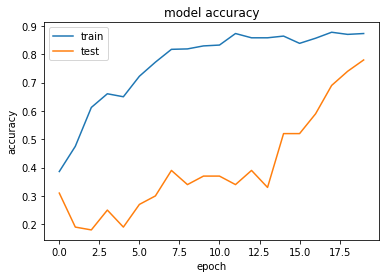

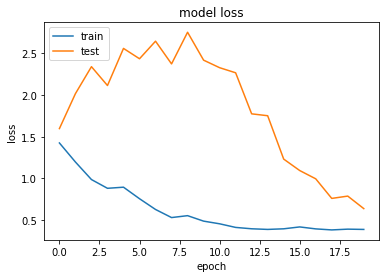

In [100]:
# Plotting the result of Model 6 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
# Best test accuracy of 87% and validation accuracy of 78 % with this model.

# Model 7 : CNN - LSTM Model , increase input image size to 160x160 

In [102]:
# Input
input_shape=(30,160,160,3)


#write your model here
CNNlstm_2 = Sequential()

CNNlstm_2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Flatten()))


CNNlstm_2.add(LSTM(128))
CNNlstm_2.add(Dropout(0.25))

CNNlstm_2.add(Dense(128,activation='relu'))
CNNlstm_2.add(Dropout(0.25))

CNNlstm_2.add(Dense(5, activation='softmax'))


#write your optimizer
optimiser = Adam()
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# compile model :
CNNlstm_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_2.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 160, 160, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 160, 160, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 80, 80, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 80, 80, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 80, 80, 32)  

In [103]:
print("Total Params in model:", CNNlstm_2.count_params())

Total Params in model: 3754597


In [104]:
def generatorLSTM1(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,160,160,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,160,160,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [105]:
train_generator = generatorLSTM1(train_path, train_doc, batch_size)
val_generator = generatorLSTM1(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [106]:
history = CNNlstm_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_293/1818313263.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNNlstm_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4808 - categorical_accuracy: 0.3575Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-12-2615_50_53.923627/model-00001-1.48075-0.35747-1.73578-0.26000.h5
34/34 [==============================] - 89s 3s/step - loss: 1.4808 - categorical_accuracy: 0.3575 - val_loss: 1.7358 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2212 - categorical_accuracy: 0.5204
Epoch 00002: saving model to model_init_2024-12-2615_50_53.923627/model-00002-1.22120-0.52036-1.95143-0.26000.h5
34/34 [==============================] - 76s 2s/step - loss: 1.2212 - categorical_accuracy: 0.5204 - val_loss: 1.9514 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0721 - categorical_accuracy:

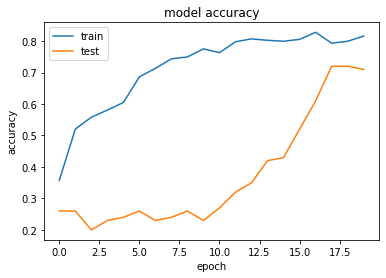

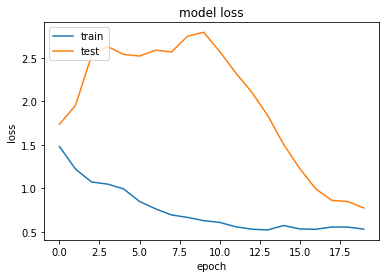

In [107]:
# Plotting the result of Model 7 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [108]:
# Got best test accuracy of 82 % and validation accuracy of 71% 

# Model 8 : CNN - LSTM Model , Increase layers , increase epoch to 25

In [109]:
input_shape=(30,120,120,3)

CNNlstm_3 = Sequential()
CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))


CNNlstm_3.add(Flatten())
CNNlstm_3.add(Dense(64,activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.25))

CNNlstm_3.add(Dense(64,activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.25))


CNNlstm_3.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam()
CNNlstm_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_3.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_55 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_33 (Conv3D)          (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_33 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_56 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                    

In [110]:
print("Total Params in model:", CNNlstm_3.count_params())

Total Params in model: 1287989


In [112]:

from datetime import datetime  # Correct import for datetime

batch_size = 20
curr_dt_time = datetime.now()  # Correct usage of datetime
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# Choose the number of epochs
num_epochs = 25
print('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 25


In [113]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [114]:
history = CNNlstm_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7565 - categorical_accuracy: 0.3590Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-12-2616_39_08.077306/model-00001-1.75652-0.35897-2.36175-0.16000.h5
34/34 [==============================] - 54s 1s/step - loss: 1.7565 - categorical_accuracy: 0.3590 - val_loss: 2.3618 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2221 - categorical_accuracy: 0.5309
Epoch 00002: saving model to model_init_2024-12-2616_39_08.077306/model-00002-1.22211-0.53092-2.37261-0.23000.h5
34/34 [==============================] - 47s 1s/step - loss: 1.2221 - categorical_accuracy: 0.5309 - val_loss: 2.3726 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0553 - categorical_accuracy:

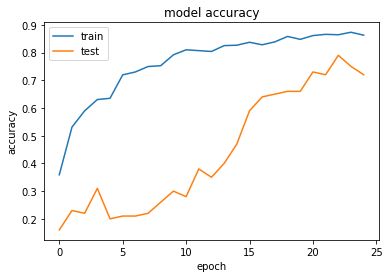

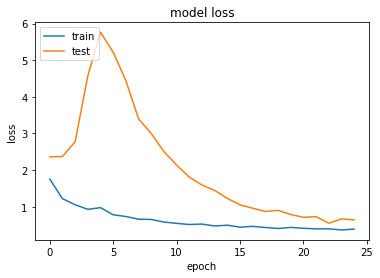

In [115]:
# Plotting the result of Model 8 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [116]:
# The best test accuracy is 86 % and best validation accuracy is 72 %

# Model 9 : CNN - LSTM Model, Increase network paramaters

In [117]:
input_shape=(30,120,120,3)

CNNlstm_4 = Sequential()
CNNlstm_4.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_4.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_4.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_4.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())
CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))


CNNlstm_4.add(Flatten())
CNNlstm_4.add(Dense(128,activation='relu'))
CNNlstm_4.add(BatchNormalization())
CNNlstm_4.add(Dropout(0.25))

CNNlstm_4.add(Dense(128,activation='relu'))
CNNlstm_4.add(BatchNormalization())
CNNlstm_4.add(Dropout(0.25))


CNNlstm_4.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam()
CNNlstm_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (CNNlstm_4.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_40 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_65 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_41 (Conv3D)          (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_41 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_66 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                    

In [118]:
print("Total Params in model:", CNNlstm_4.count_params())

Total Params in model: 1702645


In [120]:
from datetime import datetime  # Correct import for datetime

batch_size = 20

curr_dt_time = datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 25
print ('# epochs =', num_epochs)



# training sequences = 663
# validation sequences = 100
# epochs = 25


In [121]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [122]:
history = CNNlstm_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7873 - categorical_accuracy: 0.3741Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-12-2617_01_53.916471/model-00001-1.78734-0.37406-1.61549-0.34000.h5
34/34 [==============================] - 52s 2s/step - loss: 1.7873 - categorical_accuracy: 0.3741 - val_loss: 1.6155 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3806 - categorical_accuracy: 0.4706
Epoch 00002: saving model to model_init_2024-12-2617_01_53.916471/model-00002-1.38064-0.47059-1.64789-0.38000.h5
34/34 [==============================] - 50s 2s/step - loss: 1.3806 - categorical_accuracy: 0.4706 - val_loss: 1.6479 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1301 - categorical_accuracy:

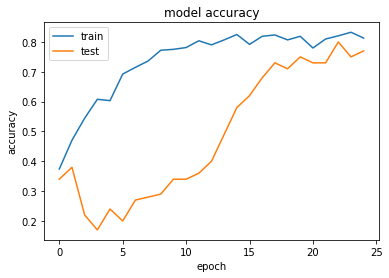

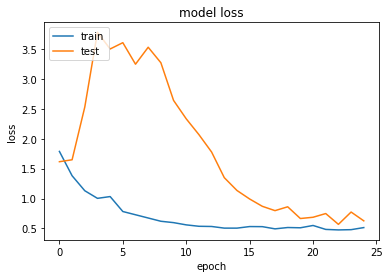

In [123]:
# Plotting the result of Model 9 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [124]:
# Got best test accuracy of 81% and validation accuracy of 77% 

# Model 10 : CNN LSTM with GRU

In [125]:
input_shape=(30,120,120,3)

GRU_lstm = Sequential()

GRU_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(input_shape)))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))


GRU_lstm.add(TimeDistributed(Flatten()))


GRU_lstm.add(GRU(128))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(128,activation='relu'))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (GRU_lstm.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 30, 60, 60, 32) 

In [126]:
print("Total Params in model:", GRU_lstm.count_params())

Total Params in model: 2573925


In [127]:
from datetime import datetime  # Correct import for datetime

batch_size = 20
curr_dt_time = datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [128]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [129]:
history = GRU_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5016 - categorical_accuracy: 0.3650Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-12-2617_27_12.144343/model-00001-1.50156-0.36501-2.11107-0.17000.h5
34/34 [==============================] - 70s 2s/step - loss: 1.5016 - categorical_accuracy: 0.3650 - val_loss: 2.1111 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
33/34 [============================>.] - ETA: 1s - loss: 1.1910 - categorical_accuracy: 0.4818
Epoch 00002: saving model to model_init_2024-12-2617_27_12.144343/model-00002-1.18809-0.48265-2.45655-0.13000.h5
34/34 [==============================] - 48s 1s/step - loss: 1.1881 - categorical_accuracy: 0.4827 - val_loss: 2.4565 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/20
33/34 [============================>.] - ETA: 1s - loss: 0.9667 - categorical_accuracy:

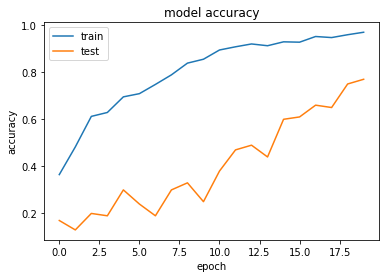

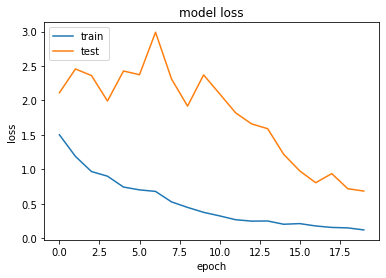

In [130]:
# Plotting the result of Model 10 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [131]:
# We have got best test accuracy of 96 % and val accuracy of 77 %

### Lets use the pre-trained model for the transfer learning.

# Model 11: Model with Transfer Learning

In [132]:
# Importing the transfer learning model:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 2s 0us/step


In [4]:
# MobileNet V2 model accepts one of the following formats: (96, 96), (128, 128), (160, 160),(192, 192), or (224, 224).
# Hence, we have got this warning for the input as we have not specified the input size while import.

In [133]:
# Building the model :

input_shape = (18,120,120,3)
        
mobileNetModel= Sequential()
mobileNetModel.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


for layer in mobileNetModel.layers:
    layer.trainable = False


mobileNetModel.add(TimeDistributed(BatchNormalization()))
mobileNetModel.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModel.add(TimeDistributed(Flatten()))

mobileNetModel.add(LSTM(128))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(128,activation='relu'))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
mobileNetModel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModel.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeDi  (None, 18, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 18, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 128)             

In [134]:
print("Total Params in model:", mobileNetModel.count_params())

Total Params in model: 3840453


In [135]:
def generatorMobileNet(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,120,120,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [136]:
from datetime import datetime  # Correct import for datetime

batch_size = 5
curr_dt_time = datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [137]:
train_generator = generatorMobileNet(train_path, train_doc, batch_size)
val_generator = generatorMobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [138]:
history = mobileNetModel.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3879 - categorical_accuracy: 0.4178Source path =  /home/datasets/Project_data/val ; batch size = 5

Epoch 00001: saving model to model_init_2024-12-2617_46_10.298680/model-00001-1.38787-0.41780-1.09435-0.64000.h5
133/133 [==============================] - 33s 220ms/step - loss: 1.3879 - categorical_accuracy: 0.4178 - val_loss: 1.0943 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9334 - categorical_accuracy: 0.6365
Epoch 00002: saving model to model_init_2024-12-2617_46_10.298680/model-00002-0.93342-0.63650-0.82019-0.70000.h5
133/133 [==============================] - 27s 207ms/step - loss: 0.9334 - categorical_accuracy: 0.6365 - val_loss: 0.8202 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5640 - categor

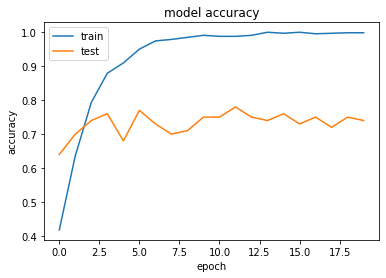

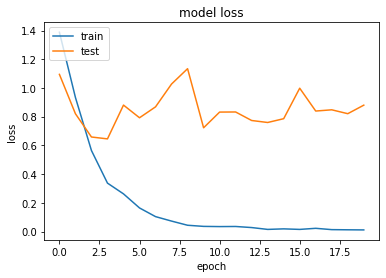

In [139]:
# Plotting the result of Model 11:

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Best test accuracy of 98 % and val accuracy of 75 %.

#### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement.

# Model 12: Transfer Learning with GRU and training all weights

In [140]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

input_shape = (18,120,120,3)
        
mobileNetModelWeight = Sequential()
mobileNetModelWeight.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


mobileNetModelWeight.add(TimeDistributed(BatchNormalization()))
mobileNetModelWeight.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModelWeight.add(TimeDistributed(Flatten()))

mobileNetModelWeight.add(GRU(128))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(128,activation='relu'))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
mobileNetModelWeight.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModel.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeDi  (None, 18, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 18, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 128)             

In [18]:
print("Total Params in model:", mobileNetModel.count_params())

Total Params in model: 3840453


In [144]:
from datetime import datetime  # Correct import for datetime

batch_size = 5
curr_dt_time = datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [145]:
train_generator = generatorMobileNet(train_path, train_doc, batch_size)
val_generator = generatorMobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [146]:
history = mobileNetModelWeight.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 0.7859 - categorical_accuracy: 0.6923Source path =  /home/datasets/Project_data/val ; batch size = 5

Epoch 00001: saving model to model_init_2024-12-2617_58_17.657238/model-00001-0.78587-0.69231-0.81135-0.72000.h5
133/133 [==============================] - 30s 224ms/step - loss: 0.7859 - categorical_accuracy: 0.6923 - val_loss: 0.8114 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6540 - categorical_accuracy: 0.7496
Epoch 00002: saving model to model_init_2024-12-2617_58_17.657238/model-00002-0.65400-0.74962-0.76974-0.75000.h5
133/133 [==============================] - 29s 219ms/step - loss: 0.6540 - categorical_accuracy: 0.7496 - val_loss: 0.7697 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4906 - categor

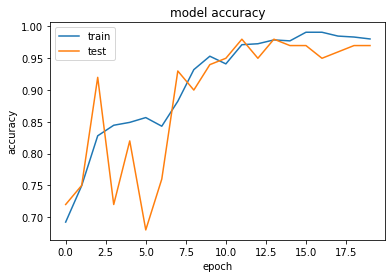

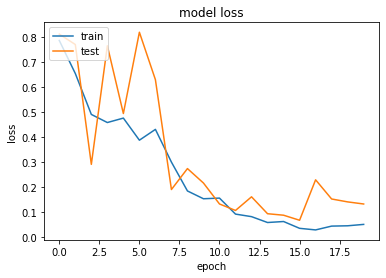

In [147]:
# Plotting the result of Model 12:

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [148]:
# Got the best test accuracy of 98 % and val accuracy of 97 %.

# Final Model Choosen :

## Transfer Learning with GRU and training all weights
#### model name :model-00020-0.05141-0.98039-0.13289-0.97000.h5